In [1]:
import pandas as pd

# Load first 1000 rows to test
df = pd.read_csv("PS_20174392719_1491204439457_log.csv", nrows=1000)

# Show first 5 rows
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
# Step 1: Install required libraries
!pip install pandas matplotlib


Defaulting to user installation because normal site-packages is not writeable


In [3]:
import sqlite3
conn = sqlite3.connect("paysim.db")
cursor = conn.cursor()


In [4]:
cursor.execute('''
    CREATE TABLE IF NOT EXISTS transactions (
        step INTEGER,
        type TEXT,
        amount REAL,
        nameOrig TEXT,
        oldbalanceOrg REAL,
        newbalanceOrig REAL,
        nameDest TEXT,
        oldbalanceDest REAL,
        newbalanceDest REAL,
        isFraud INTEGER,
        isFlaggedFraud INTEGER
    )
''')
conn.commit()


In [5]:
# Check that table exists
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())


[('transactions',)]


In [6]:
df.columns


Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [7]:
df['month']= (df['step']//720)+1
df[['step','month']].head()

,step,month
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


In [8]:
#1hr=1step so 24hr(1day)=24step Iwant 1month so 30 day so 30x24=720
#Hum chahte hain har 720 hours (i.e. 1 month) ko ek month number de dein:

#Step Range   	Month
#0 to 719	      1 0to719 range step when divide by 720 gives 0 so +1 so all assign with 1
#720 to 1439	  2
#1440 to 2159	  3 that why we are dividing by 720 and want month starts from 1 so+1
df['month']= (df['step']//720)+1
df[['step','month']].head()

,step,month
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


In [9]:
#KPI 1 – Monthly Transacting Users
query = """
SELECT (step / 720) + 1 AS month,
       COUNT(DISTINCT nameOrig) AS mtu
FROM transactions
WHERE isFraud = 0
GROUP BY month
ORDER BY month;
"""
mtu_df = pd.read_sql_query(query, conn)
mtu_df


,month,mtu
0,1,6345122


In [10]:
# KPI 2: Churned Users
#Goal: Find users who were active in month M but did not return in month M+1This helps measure user drop-off / churn

query = """
WITH user_month AS (
    SELECT DISTINCT nameOrig AS user_id,
                    (step / 720) AS month
    FROM transactions
    WHERE isFraud = 0
),
churnedUser AS (
    SELECT this_month.user_id,
           this_month.month AS churn_month
    FROM user_month AS this_month
    LEFT JOIN user_month AS next_month
      ON this_month.user_id = next_month.user_id
     AND this_month.month + 1 = next_month.month
    WHERE next_month.user_id IS NULL
)
SELECT churn_month, COUNT(DISTINCT user_id) AS churned_user
FROM churnedUser
GROUP BY churn_month
ORDER BY churn_month;
"""
churn_df = pd.read_sql_query(query, conn)
churn_df


,churn_month,churned_user
0,0,6345122


In [11]:
#KPI 3: Power Users
#Goal: Find top 10 users who did the most number of transactions
#(safe transactions — isFraud = 0)
query = """
SELECT nameOrig AS user_id,
       COUNT(*) AS total_txns
FROM transactions
WHERE isFraud = 0
GROUP BY user_id
ORDER BY total_txns DESC
LIMIT 10;
"""
power_users_df = pd.read_sql_query(query, conn)
power_users_df




,user_id,total_txns
0,C724452879,3
1,C545315117,3
2,C400299098,3
3,C363736674,3
4,C2098525306,3
5,C2051359467,3
6,C1999539787,3
7,C1976208114,3
8,C1902386530,3
9,C1832548028,3


In [12]:
# Next Up: KPI 4 – Revenue Growth (Monthly)
# Goal:What is the total transaction amount for each month, only for non-fraud (safe) transactions?
query = """
SELECT (step / 720) AS month,
       SUM(amount) AS total_revenue
FROM transactions
WHERE isFraud = 0
GROUP BY month
ORDER BY month;
"""
revenue_df = pd.read_sql_query(query, conn)
revenue_df






,month,total_revenue
0,0,1.132337e+12


In [13]:
#Funnel Analysis
# Track how many users go from:
# CASH_IN → TRANSFER
query = """
WITH cash_in_users AS (
    SELECT DISTINCT nameOrig AS user_id
    FROM transactions
    WHERE type = 'CASH_IN' AND isFraud = 0
),
transfer_users AS (
    SELECT DISTINCT nameOrig AS user_id
    FROM transactions
    WHERE type = 'TRANSFER' AND isFraud = 0
)
SELECT
    (SELECT COUNT(*) FROM cash_in_users) AS total_cash_in_users,
    (SELECT COUNT(*) FROM transfer_users) AS total_transfer_users,
    (SELECT COUNT(*) FROM cash_in_users
     WHERE user_id IN (SELECT user_id FROM transfer_users)) AS converted_users;
"""
funnel_df = pd.read_sql_query(query, conn)
funnel_df



,total_cash_in_users,total_transfer_users,converted_users
0,1398845,528744,318


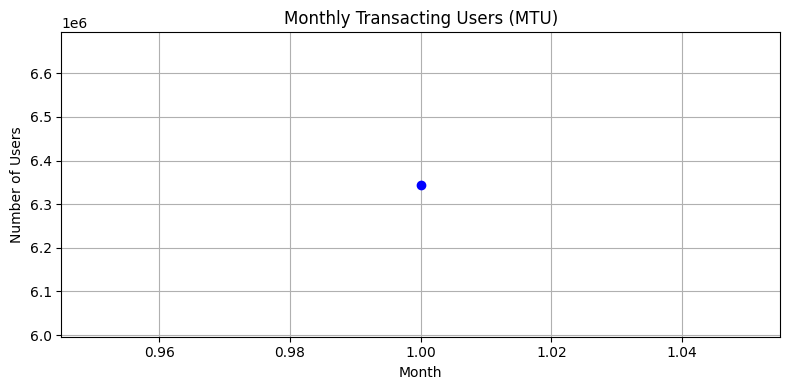

In [14]:
#Line Chart – MTU Trend

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(mtu_df['month'], mtu_df['mtu'], marker='o', color='blue')
plt.title('Monthly Transacting Users (MTU)')
plt.xlabel('Month')
plt.ylabel('Number of Users')
plt.grid(True)
plt.tight_layout()
plt.show()


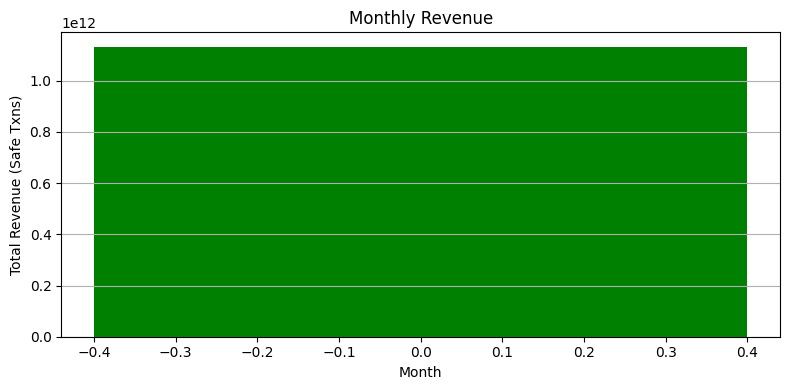

In [15]:
# Bar Chart – Monthly Revenue
plt.figure(figsize=(8, 4))
plt.bar(revenue_df['month'], revenue_df['total_revenue'], color='green')
plt.title('Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Total Revenue (Safe Txns)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()




In [16]:
#KPI: Top Transaction Per User (Window Function)
query = """
WITH ranked_txns AS (
  SELECT 
    nameOrig AS user_id,
    amount,
    type,
    step,
    ROW_NUMBER() OVER (PARTITION BY nameOrig ORDER BY amount DESC) AS rn
  FROM transactions
  WHERE isFraud = 0
)
SELECT * 
FROM ranked_txns
WHERE rn = 1
LIMIT 10;
"""

top_txn_df = pd.read_sql_query(query, conn)
top_txn_df



,user_id,amount,type,step,rn
0,C1000000639,244486.46,CASH_OUT,249,1
1,C1000001337,3170.28,PAYMENT,217,1
2,C1000001725,8424.74,PAYMENT,46,1
3,C1000002591,261877.19,CASH_IN,231,1
4,C1000003372,20528.65,CASH_IN,167,1
5,C1000003615,49360.77,CASH_IN,254,1
6,C1000004053,211189.64,CASH_OUT,327,1
7,C1000004530,93865.13,CASH_OUT,41,1
8,C1000005353,3228390.11,TRANSFER,226,1
9,C1000005555,233109.79,CASH_OUT,185,1
